# Transfer Learning EfficientNet on Animal Data

## Imports & Others

In [1]:
import torch

In [2]:
# Setup agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data

In [3]:
# Import data from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals") + "/animals/animals"

print("Path to dataset files:", path)

100%|██████████| 656M/656M [00:16<00:00, 41.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals


In [4]:
from torchvision import datasets, transforms, models

transform = models.EfficientNet_B2_Weights.DEFAULT.transforms()

# Create a Dataset with image transformations
full_dataset = datasets.ImageFolder(root=path, transform=transform)
classes = full_dataset.classes

print(f"Total size: {len(full_dataset)} | Total Classes: {len(classes)}")

Total size: 5400 | Total Classes: 90


In [5]:
from torch.utils.data import random_split, DataLoader

# Divide Train & Test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Train Dataset Size: 4320
Test Dataset Size: 1080


In [6]:
# Put datasets on dataloaders for training and testing
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batches on Train: {len(train_dataloader)}")
print(f"Batches on Test: {len(test_dataloader)}")

Batches on Train: 135
Batches on Test: 34


## Model

In [110]:
# Create a EfficientNetb2 Pretrained Model
model_effnetb2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)

In [111]:
# Frozen all parameters
for param in model_effnetb2.parameters():
  param.requires_grad = False

In [41]:
# Check the size of pixel redimension for simulating architecture
models.EfficientNet_B2_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [114]:
# Show model architecture
try:
  import torchinfo
except:
  !pip install -q torchinfo
  import torchinfo

torchinfo.summary(model_effnetb2, input_size=(1, 3, 288, 288), col_names=["input_size", "output_size", "num_params", "trainable",])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 288, 288]          [1, 90]                   --                        Partial
├─Sequential: 1-1                                       [1, 3, 288, 288]          [1, 1408, 9, 9]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 288, 288]          [1, 32, 144, 144]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 288, 288]          [1, 32, 144, 144]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 144, 144]         [1, 32, 144, 144]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 144, 144]         [1, 32, 144, 144]         --                        --
│    └─Sequential

In [113]:
# Change the classifier layer adapting to our problem
from torch import nn

model_effnetb2.classifier = nn.Sequential(nn.Dropout(0.2, inplace=True), nn.Linear(1408, len(classes))) # The value comes from seeing the architecture

## Train

In [10]:
from tqdm.auto import tqdm

def train_step(model, train_dataloader, loss_fn, optimizer, device):
  model.train()
  model.to(device)

  train_loss, train_acc = 0, 0

  for batch, (X, y) in tqdm(enumerate(train_dataloader)):
    # 0. Data to GPU
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_logits = model(X)
    y_preds = y_logits.argmax(1)

    # 2. Calculate loss & acc
    loss = loss_fn(y_logits, y)
    train_loss += loss
    train_acc += (y_preds == y).sum().item()/len(y_preds)

    # 3. Erase gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Step
    optimizer.step()

  return train_loss / len(train_dataloader), train_acc / len(train_dataloader)

In [11]:
def test_step(model, test_dataloader, loss_fn, device):
  model.eval()
  model.to(device)

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in tqdm(enumerate(test_dataloader)):
      # 0. Send data to GPU
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_logits = model(X)
      y_preds = y_logits.argmax(1)

      # 2. Calculate loss & acc
      loss = loss_fn(y_logits, y)
      test_loss += loss
      test_acc += (y_preds == y).sum().item() / len(y_preds)

  return test_loss / len(test_dataloader), test_acc / len(test_dataloader)

In [17]:
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs = 5):
  # Create empty results dictionary
  results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

    # Print out what's happening
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc*100:.2f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc*100:.2f}"
    )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [115]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

results = train(model_effnetb2, train_dataloader, test_dataloader, nn.CrossEntropyLoss(), torch.optim.Adam(model_effnetb2.parameters(), 0.001), device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 2.3052 | train_acc: 67.94 | test_loss: 1.0040 | test_acc: 88.11


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.6352 | train_acc: 90.74 | test_loss: 0.5479 | test_acc: 91.27


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.3806 | train_acc: 93.96 | test_loss: 0.4234 | test_acc: 91.76


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.2741 | train_acc: 95.95 | test_loss: 0.3652 | test_acc: 91.57


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.2183 | train_acc: 96.57 | test_loss: 0.3266 | test_acc: 92.59
[INFO] Total training time: 583.607 seconds


## Evaluation

In [38]:
import matplotlib.pyplot as plt

# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = [result.item() for result in results["train_loss"]]
    test_loss = [result.item() for result in results["test_loss"]]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


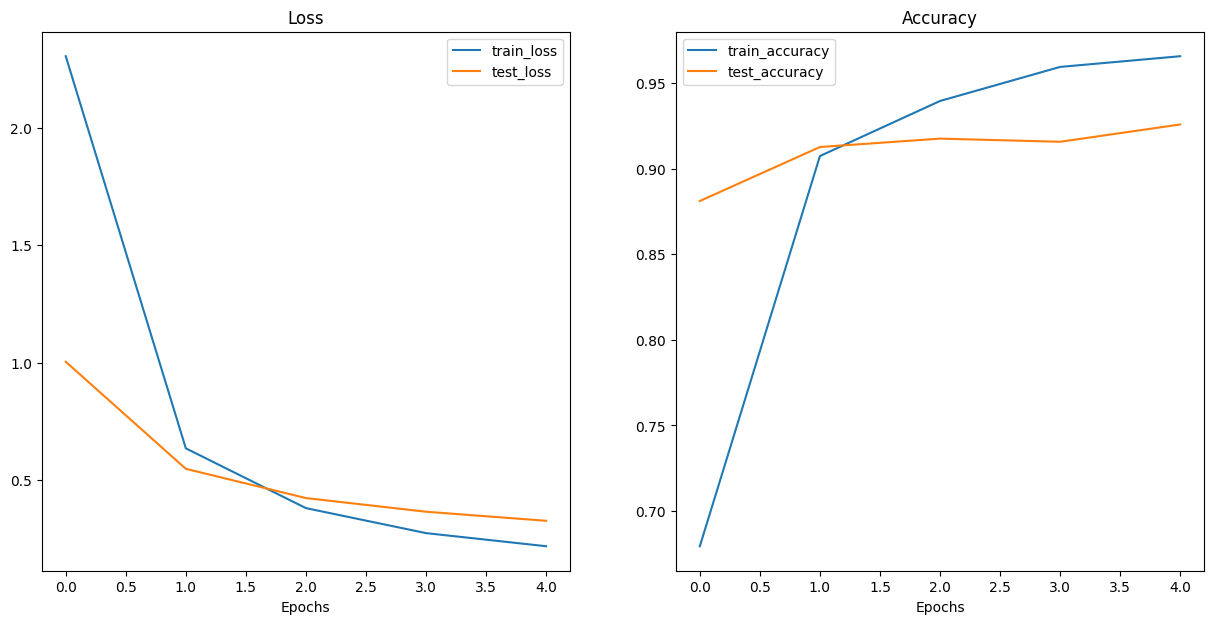

In [118]:
plot_loss_curves(results)

### Testing Predictions

In [120]:
from torchvision.io import read_image
import matplotlib.pyplot as plt
from pathlib import Path
import random

def plot_k_preds(model, test_image_path_list, num_images = 5, transforms = transform):
  # Get a random list of image paths from test set
  test_image_path_sample = random.sample(population=test_image_path_list, k=num_images) # randomly select 'k' image paths

  plt.figure(figsize=(20,10))

  model.eval()
  model.to(device)
  # Make predictions on and plot the images
  for i, image_path in enumerate(test_image_path_sample):
    # Prepare the image for the model
    img_raw = read_image(image_path)
    img = transform(img_raw)

    with torch.inference_mode():
      y_logits = model(img.unsqueeze(0).to(device))
      y_probs = torch.softmax(y_logits, 1)
      y_pred = y_probs.argmax(1)
      y_label = classes[y_pred]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img_raw.permute(1, 2, 0))

    title = f"Real Class: {image_path.parent.name} | Pred Class: {y_label}"

    plt.title(title, c = "g" if (image_path.parent.name == y_label) else "r")
    plt.axis(False)



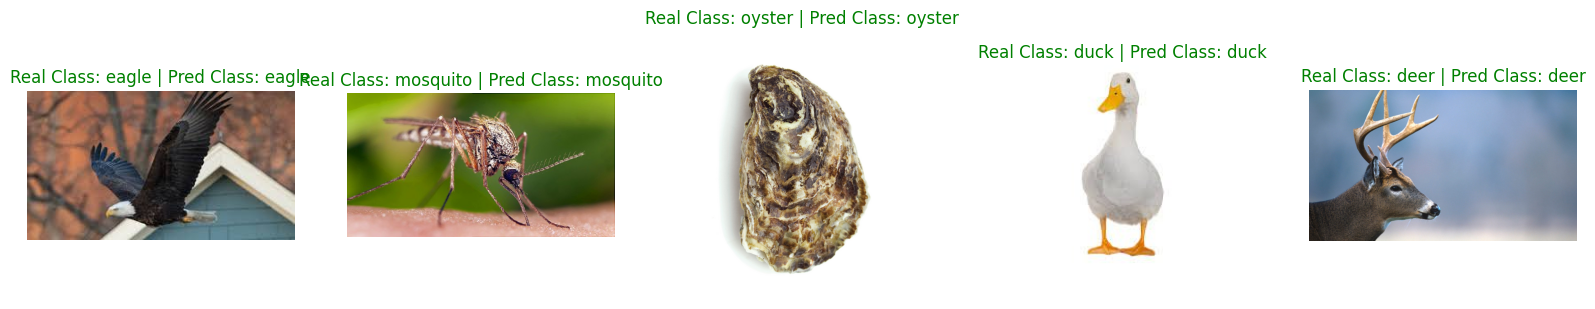

In [136]:
plot_k_preds(model_effnetb2_example, list(Path(path).glob("*/*.jpg")), 5)

## Save Model

In [116]:
from pathlib import Path

model_dir = Path("models")
model_dir.mkdir(exist_ok=True)

# Model name
model_name = "effnetb2_tfv1_animaldata.pth"

model_path = model_dir / model_name

torch.save(model_effnetb2.state_dict(), model_path)

In [135]:
# Check that model loads correctly
model_effnetb2_example = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
model_effnetb2_example.classifier = nn.Sequential(nn.Dropout(0.2, inplace=True), nn.Linear(1408, len(classes))) # The value comes from seeing the architecture

model_effnetb2_example.load_state_dict(torch.load(model_path))

<All keys matched successfully>